# Previsão de Preço com Regressão Linear 

Suponha que temos um site onde as pessoas podem vender e comprar carros usados. Ao postar um anúncio em nosso site, os vendedores geralmente lutam para encontrar um preço significativo. Queremos ajudar nossos usuários com recomendações automáticas de preços. Pedimos aos vendedores que especifiquem o modelo, marca, ano, quilometragem e outras características importantes de um carro e, com base nessas informações, queremos sugerir o melhor preço .

Um dos gerentes de produto da empresa acidentalmente encontrou um conjunto de dados aberto com preços de carros e nos pediu para dar uma olhada. Verificamos os dados e vimos que continham todos os recursos importantes, bem como o preço recomendado - exatamente o que precisávamos para nosso caso de uso. Assim, decidimos usar esse conjunto de dados para construir o algoritmo de recomendação de preço.


## Analise Exploratória de dados 

In [1]:
# importações
import numpy as np # operações numericas 
import pandas as pd # dados tabulares 

from matplotlib import pyplot as plt 
import seaborn as sns 
# diz ao jupyter para esperar gráficos no notebook, para que ele possa renderiza-los
%matplotlib inline 

In [2]:
# Lendo e preparando os dados 
df = pd.read_csv('data.csv')

In [3]:
# verificando quantas linhas existem
len(df) #existem quase 12mil carros nesse dataset

11914

In [4]:
# verificando as cinco primeiras linhas do df
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


Analisando, logo percebemos que os nomes das colunas as vezes possuem espaços e outras sublinhados ( _ ). Isso é inconveniente e confuso, mas podemos resolver isso normalizando os substituindo todos os espaços por sublinhados e todas as letras minusculas 

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
string_columns = list(df.dtypes[df.dtypes == 'object'].index) # selecionamos colunas com valores strings
 
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

Utilizamos o atributo especial str. Usando-o, podemos aplicar operações de string a toda a coluna ao mesmo tempo sem escrever nenhum `for`.
Nós o usamos para colocar em letras minusculas os nomes das colunas e o conteúdos dessas colunas bem como para substituir os espaços por sublinhados. 

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


Colunas do dataset

`make`: marca de um carro (BMW, Toyota e assim por diante)

`modelo`: modelo de um carro

`ano`: ano em que o carro foi fabricado

`engine_fuel_type`: tipo de combustível que o motor precisa (diesel, elétrico e assim por diante)

`engine_hp`: potência do motor

`engine_cylinders`: número de cilindros no motor

`tipo_transmissão`: tipo de transmissão (automática ou manual)

`drive_wheels`: dianteiro, traseiro, todos

`number_of_doors`: número de portas que um carro tem

`market_category`: luxo, crossover e assim por diante

`Vehicle_size`: compacto, médio ou grande

`estilo_veículo`: sedã ou conversível

`Highway_mpg`: milhas por galão (mpg) na rodovia

`city_mpg`: milhas por galão na cidade

`popularidade`: número de vezes que o carro foi mencionado em um stream do Twitter

`msrp`: preço de varejo sugerido pelo fabricante

Usaremos a ultima coluna para prever os preços dos carros 

### Analise da Variavel alvo 

A coluna MSRP contém informações importantes - É a nossa variavel de destino, o y, que é o valor que queremos aprender a prever

<AxesSubplot:xlabel='msrp', ylabel='Count'>

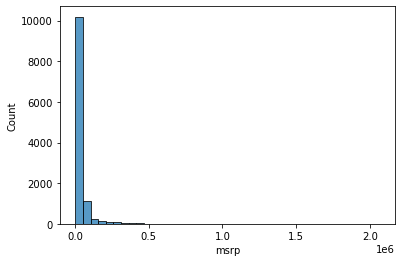

In [7]:
# hsitograma - observar os valores de y 
sns.histplot(df.msrp, bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

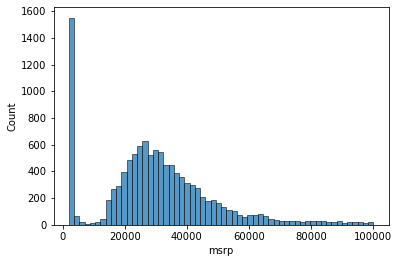

In [8]:
# ampliando e verificando valores abaixos de US$ 100.00 
sns.histplot(df.msrp[df.msrp < 100000])

Notamos que muitos carros custam US$ 1.000

A cauda longa torna bastante difícil para nós ver a distribuição, mas tem um efeito ainda mais forte em um modelo : tal distribuição pode confundir muito o modelo, então ele não aprenderá bem o suficiente. Uma maneira de resolver esse problema é a transformação de log . Se aplicarmos a função log aos preços, remove o efeito indesejado

`ynew = log(y + 1)`

In [9]:
# função numpy para realizar a transformação
# calcula o logaritmo natural (x+1) dos valores presentes na coluna "msrp"
log_price = np.log1p(df.msrp) 

<AxesSubplot:xlabel='msrp', ylabel='Count'>

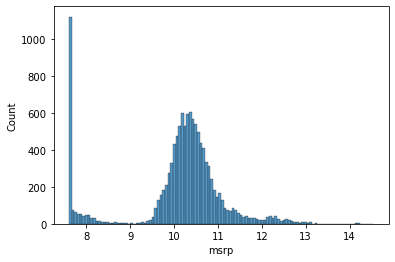

In [10]:
# verificando a distribuição dos preços apos a transformação
sns.histplot(log_price)

### Verificação dos valores ausentes

In [11]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

Analisamos nossa variavel de destino (msrp), ela não possui valores ausentes e isso é bom pois será muito util.

### Estrutura de validação

Iremos dividir nosso dataset em três partes: treino, validação e teste 

60% - treino

20% - validação 

20% - testes 



In [12]:
# dividindo os dados 
n = len(df) # obtem o numero total de linhas do df
 
n_val = int(0.2 * n) #Calcula o numero de amostras(20%)
n_test = int(0.2 * n) # Calcula o numero de amostras (20%)
n_train = n - (n_val + n_test) #Calcula o numero de amostras (60%)
 
np.random.seed(2) #Define a semente do gerador de numeros aleatorios para garantir que toda vez que o executarmos, os resultados sejam os mesmos
idx = np.arange(n) #Cria um array de numeros inteiros sequencias de 0 a 'n-1'
np.random.shuffle(idx) # embaralha aleatoriamente os elementos do array 'idx'. Reeordenando aleatoriamente os indices dos dados
 
df_shuffled = df.iloc[idx] # aplica a nova ordem dos indices ao df original, criando um novo df
 
df_train = df_shuffled.iloc[:n_train].copy() # seleciona as primeiras 'n_train' linhas do dataframe df.shuffled   
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy() # seleciona as proximas 'n_val' linhas do df embaralhado
df_test = df_shuffled.iloc[n_train+n_val:].copy() # seleciona as linhas restantes do df embaralhado a partir da posição 'n_train + n_val'

# A função copy() é usada para garantir que uma cópia dos dados seja feita em vez de uma referência aos dados originais.


In [13]:
# devido a cauda longa, devemos aplicar a transformação logaritmica 
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

Para evitar o uso acidental da variável de destino posteriormente, vamos removê-la dos dataframes :

In [14]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

**Obs.** A remoção da variável de destino é uma etapa opcional. Mas é útil garantir que não o usamos ao treinar um modelo: se isso acontecer, usaríamos o preço para prever o preço e nosso modelo teria precisão perfeita .

## Prevendo o preço com ML


In [15]:
# Regressão Linear implementada com NumPy
def train_linear_regression(X, y):
    # adding the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
   
    # normal equation formula
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
   
    return w[0], w[1:]

Já preparamos o y , mas ainda não temos o X : o que temos agora é um quadro de dados, não uma matriz. Portanto, precisamos extrair alguns recursos do nosso conjunto de dados para criar essa matriz X .

engine_hp

motores_cilindros

rodovia_mpg

city_mpg

popularidade

Vamos selecionar os recursos do quadro de dados e escrevê-los em uma nova variável, df_num:

In [16]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
        'popularity']
df_num = df_train[base]

Vimos que no dataset algumas linhas possuem valores ausentes.
A melhor maneira para corrigirmos isso é preenchendo com outro valor 

Iremos preencher os valores ausentes com 0 usando o método `fillna` do pandas

In [17]:
df_num = df_num.fillna(0)

**OBSERVAÇÃO:** Uma opção alternativa é substituir os valores ausentes pelos valores médios. Para algumas variáveis, por exemplo, o número de cilindros, o valor zero não faz muito sentido: um carro não pode ter cilindros zero. No entanto, isso tornará nosso código mais complexo e não terá um impacto significativo nos resultados. É por isso que seguimos uma abordagem mais simples e substituímos os valores ausentes por zeros .

In [18]:
# Convertendo o dataframe em um array numpy 
X_train = df_num.values

In [19]:
w_0, w = train_linear_regression(X_train, y_train)

Acabamos de treinar nosso modelo! Agora podemos aplicá-lo aos dados de treinamento para ver o quão bom ele prevê: 

In [20]:
y_pred = w_0 + X_train.dot(w)

implementamos um histplot para traçar os valores previstos e compará-los com os valores reais

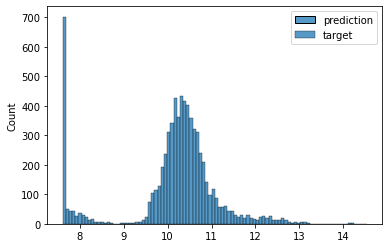

In [61]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()

Podemos ver que a distribuição de valores que previmos parece bem diferente dos valores reais. Esse resultado pode indicar que o modelo não é poderoso o suficiente para capturar a distribuição da variável alvo. Isso não deve ser uma surpresa para nós: o modelo que usamos é bastante básico e inclui apenas cinco recursos muito simples .

In [22]:
#RMSE

def rmse(y, y_pred):
    error = y_pred - y # calculamos a diferença entre previsoes e os preços reais
    mse = (error ** 2).mean() # calculamos o quadrado de cada elemento do array error / em seguida, obter o valor médio do resultado
    return np.sqrt(mse) # Calculamos a raiz quadrada do mse

In [23]:
# usando RMSE para avaliar nosso modelo 
rmse(y_train, y_pred)

0.7554192603920132

O código imprime 0,75. Esse número nos diz que, em média, as previsões do modelo estão erradas em 0,75. Este resultado por si só pode não ser muito útil, mas podemos usá-lo para comparar este modelo com outros modelos. Se um modelo tiver um RMSE melhor (mais baixo) do que o outro, isso indica que o modelo é melhor.

## Validando o Modelo 

In [24]:
# Primeiro, criamos a matriz X_val, seguindo os mesmos passos para X_train
df_num = df_val[base] 
df_num = df_num.fillna(0) 
X_val = df_num.values

In [25]:
y_pred = w_0 + X_val.dot(w)

O array y_pred contém as previsoes para o conjuntos de dados de validação. Agora nós usamos `y_pred` para comparar com os preços reais de `y_val`, usando a função RMSE que implementamos anteriormente: 


In [26]:
rmse(y_val, y_pred)

0.7616530991301591

No código anterior, já vemos alguma duplicação: os testes de treinamento e validação requerem o mesmo pré-processamento e escrevemos o mesmo código duas vezes. Portanto, faz sentido mover essa lógica para uma função separada e evitar a duplicação do código.

In [27]:
# Função para converter um DataFrame em uma Matriz
def prepare_X(df): 
    df_num = df[base] 
    df_num = df_num.fillna(0) 
    X = df_num.values
    return X

In [28]:
# Agora todo o treino e avaliação ficam mais simples ficando assim: 

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
 
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.7616530991301591


## Engenharia de Recursos Simples 

Já temos um modelo de linha de base simples com recursos simples. Para melhorar ainda mais nosso modelo, podemos adicionar mais recursos ao modelo: criamos outros e os adicionamos aos recursos existentes. Como já sabemos, esse processo é chamado de engenharia de recursos .

Nosso objetivo é melhorar o RMSE calculado sobre os dados de validação .

Primeiro, criamos um novo elemento, “idade”, a partir do elemento “ano”. A idade de um carro deve ser muito útil para prever seu preço: intuitivamente, quanto mais novo o carro, mais caro ele deve ser.

In [29]:
df_train.year.max() #dataset criado em 2017

2017

In [30]:
df_train['age'] = 2017 - df_train.year

Já sabemos que precisaremos aplicar o mesmo pré-processamento duas vezes: nos conjuntos de treinamento e validação. Como não queremos repetir o código de extração de recurso várias vezes, vamos colocar essa lógica no prepare_Xfunção

In [31]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
 
    df['age'] = 2017 - df.year
    features.append('age')
 
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

Vamos testar se adicionar o recurso `idade` leva a alguma melhoria: 

In [32]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5172055461058329


Houve uma boa melhoria, concluimos que adicionar "idade" é realmente util ao fazer previsoes 


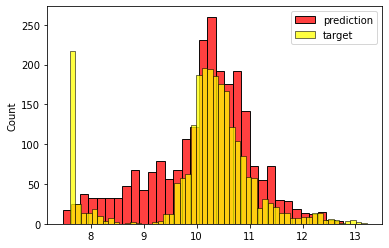

In [35]:
# observando a distribuição dos valores previstos
sns.histplot(y_pred, label='prediction', color='red')
sns.histplot(y_val, label='target', color='yellow')
plt.legend()

### Manipulação de variaveis categóricas 

Variavel numero de portas (2, 3 e 4) 
Embora seja tentador colocar a variável no modelo como está, ela não é bem uma variável numérica: não podemos dizer que adicionando mais uma porta, o preço de um carro aumenta (ou diminui) uma certa quantia de dinheiro. Em vez disso, a variável é categórica.

Usaremos um método de codificação de variaveis categóricas chamado codificação one-hot

**One-hot encoding**  é uma técnica utilizada em ciência de dados e aprendizado de máquina para representar variáveis categóricas como vetores numéricos binários.

Quando temos uma variável categórica, como por exemplo "cor" com os valores "vermelho", "verde" e "azul", não podemos simplesmente atribuir valores numéricos como 1, 2 e 3, pois isso pode gerar uma relação de ordem indesejada entre as categorias.

No one-hot encoding, cada categoria é representada por um vetor binário de tamanho igual ao número total de categorias possíveis. O vetor contém apenas zeros, exceto pelo índice correspondente à categoria em questão, que é definido como 1. Por exemplo, usando o one-hot encoding para representar as cores, teríamos:

`"vermelho" = [1, 0, 0]`

`"verde" = [0, 1, 0]`

`"azul" = [0, 0, 1]`

In [42]:
#for v in [2, 3, 4]:
#    feature = 'num_doors_%s' % v
#    value = (df['number_of_doors'] == v).astype(int) # para converter séries com valores booleanos para inteiros
#    df[feature] = value
#   features.append(feature)

Podemos usar a mesma abordagem para codificar outras variáveis categóricas. Vamos começar com `make`. Para nossos propósitos, deve ser suficiente obter e usar apenas os valores que ocorrem com mais frequência.

In [39]:
# analisando os cinco valores mais frequentes 
df['make'].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [43]:
# fazemos a mesma coisa do código anterior 
#for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']: 
#    feature = 'is_make_%s' % v 
#    df[feature] = (df['make'] == v).astype(int)
#    features.append(feature)

a função prepareX depois de manipular variáveis categóricas number_of_dors e make

In [41]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
 
    df['age'] = 2017 - df.year
    features.append('age')
 
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
 
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

Vamos verificar se o código melhora o RMSE do modelo: 

In [44]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val) 
y_pred = w_0 + X_val.dot(w) 
print('validation: ', rmse(y_val, y_pred))

validation:  0.5076038849555177


O valor anterior era 0,517, então conseguimos melhorar ainda mais a pontuação do RMSE.

Podemos usar mais algumas variáveis: engine_fuel_type, transmission_type, driven_ wheels, market_category, vehicle_size, e vehicle_style. Vamos fazer a mesma coisa por eles. Após as modificações, o prepare_Xcomeça a parecer um pouco mais complexo.

In [45]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
 
    df['age'] = 2017 - df.year
    features.append('age')
 
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
 
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
 
    for v in ['regular_unleaded', 'premium_unleaded_(required)',
              'premium_unleaded_(recommended)',
              'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
 
    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
 
    for v in ['front_wheel_drive', 'rear_wheel_drive',
              'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)
 
    for v in ['crossover', 'flex_fuel', 'luxury',
              'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)
 
    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)
 
    for v in ['sedan', '4dr_suv', 'coupe', 'convertible',
              '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [47]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
 
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 129.88777839125433


O numero que vemos é significativamente pior do que antes

Em vez de ajudar, os novos recursos pioraram muito o placar. Felizmente, temos validação para nos ajudar a identificar esse problema

### Regularização 

O objetivo da regularização é garantir que o inverso exista, forçando a matriz a ser invertível. A regularização é um conceito importante no aprendizado de máquina: significa “controlar” — controlar os pesos do modelo para que eles se comportem corretamente e não cresçam muito, como no nosso caso .

Vamos criar uma nova função que use essa ideia e implemente a regressão linear com regularização .

In [48]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
 
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
 
    return w[0], w[1:]

Vamos verificar o que acontece com nossos pesos para diferentes valores de r:

In [49]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, -298620427184285.38, 5.30, 298620427174107.06
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


Agora vamos verificar se a regularização ajuda com nosso problema e qual RMSE obtemos depois disso. Vamos executá-lo com r=0,001:

In [51]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
 
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.4602267626001815


Esse resultado tem uma melhora em relação a pontuação anterior

**OBSERVAÇÃO**
Às vezes, quando a adição de um novo recurso causa degradação do desempenho, a simples remoção desse recurso pode ser suficiente para resolver o problema. Ter um conjunto de dados de validação é importante para decidir se adiciona regularização, remove o recurso ou ambos: usamos a pontuação nos dados de validação para escolher a melhor opção. No nosso caso particular, vemos que adicionar regularização ajuda: melhora a pontuação que tínhamos anteriormente.

In [52]:
# Vamos tentar com outros valores de r

X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
 
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46022555830557693
0.0001 0.46022548918124023
 0.001 0.4602267626001815
  0.01 0.46023949636400013
   0.1 0.4603700695791139
     1 0.46182980426584974
     5 0.46840796275339863
    10 0.47572481006961614


Vemos que o melhor desempenho é alcançado com um menor `r`

Também notamos que o desempenho para valores abaixo de 0,1 não muda muito 

Vamos definir `r = 0,01` como modelo final

In [53]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
 
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))
 
X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.46023949636400013
test: 0.45718136798835907


Como esses dois números são muito próximos, concluímos que o modelo pode generalizar bem para os novos dados não vistos.

## Usando o Modelo

Suponha que um usuário publique o seguinte anúncio em nosso site:

In [54]:
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2013
}

Gostaríamos de sugerir o preço deste carro. Para isso, usamos nosso modelo:

In [56]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)

In [57]:
# aplicando nosso modelo à matriz para prever o preço deste carro 
y_pred = w_0 + X_test.dot(w)

Essa previsão não é o preço final; é o logaritmo do preço. Para obter o preço real, precisamos desfazer o logaritmo e aplicar a função expoente:

In [58]:
suggestion = np.expm1(y_pred)
suggestion

array([28294.13589544])

A saída é 28.294,13. O preço real deste carro é $ 31.120, então nosso modelo não está muito longe do preço real .